# Glacier dynamics toy model

Toy model based on the Shallow Ice Approximation (SIA), mixing
partial differential equations (PDEs), neural networks and model
interpretation using SINDy.

The equation we are going to use is 

$$ \frac{\partial H}{\partial t} = \dot b + \nabla \cdot \left( \left( u_b + \frac{2A}{n+2} H \right) H^{n+1} (\rho g)^n  \, || \nabla S ||^{n-1} \nabla S \right) $$

with 
- $n$ the exponent in Glen's Law
- $A$ the deformation sliding factor in Glen's Law
- $u_b$ is the basal slip velocity 
- $\dot b$ the mass balance 

Assiming that the basal slip velocity is zero and ignoring the mass balance term, the SIA equation is equivalent to the 2D diffusivity equation 

$$ \frac{\partial H}{\partial t} = \nabla \cdot \left( D \, \nabla (B + H) \right) $$

where $B$ is the coordinate of the bed (fixed) and $D$ is the diffusivity coefficient given by 

$$ D (H, \nabla S) = \frac{2A}{n+2}(\rho g)^n H^{n+2} || \nabla S ||^{n-1} $$

In [1]:
## Environment and packages
#cd(@__DIR__)
#using Pkg; Pkg.activate("."); Pkg.instantiate()
using Infiltrator
#using Debugger

# using Flux, DiffEqFlux, DataDrivenDiffEq
# using Flux: @epochs
# using Zygote
using Plots
using Measures
gr()
using Base: @kwdef
using Statistics
using ModelingToolkit
using LinearAlgebra
using CartesianGrids
using HDF5
# Set a random seed for reproduceable behaviour
using Random

### Types

In [2]:
# what is the difference between using @kwdef and using the default constructor?

@kwdef mutable struct Hyperparameters
    batchsize::Int = 500     # batch size
    η::Float64 = 0.1         # learning rate
    epochs::Int = 500        # number of epochs
    use_cuda::Bool = true    # use gpu (if cuda available)
end

mutable struct Glacier
    bed::Array{Float32}    # bedrock height
    thick::Array{Float32}  # ice thickness
    vel::Array{Float32}    # surface velocities
end

### Functions

### Load the data

- Do we have the lat/lon of each pixel/entry of the matrices? If not, it could be useful to include them in `Glacier`

In [3]:
# Load the HDF5 file with Harry's simulated data
root_dir = pwd()
argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres.h5"), "r")

🗂️ HDF5.File: (read-only) /Users/facundosapienza/Dropbox/Glacier UDE/odinn_toy/data/Argentiere_2003-2100_aflow2e-16_50mres.h5
├─ 🔢 bed
├─ 🔢 thick_hist
└─ 🔢 vel_hist

In [4]:
# Fill the Glacier structure with the retrieved data
argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                     HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,:],
            HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,:]);

In [5]:
nx = size(argentiere.bed)[1]
ny = size(argentiere.bed)[2]

189

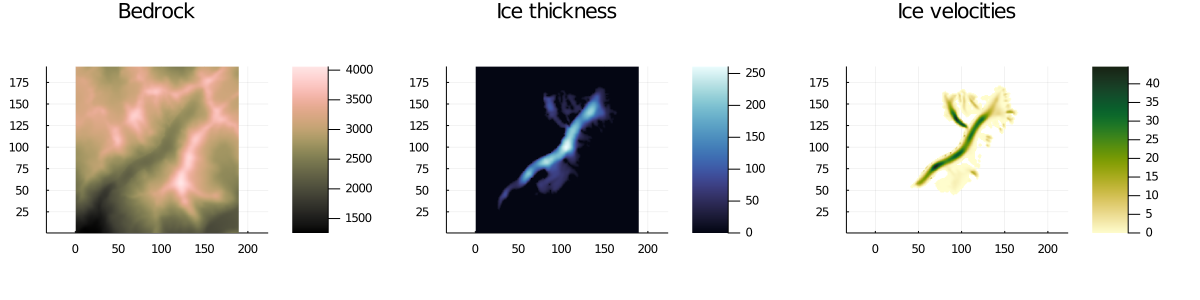

In [6]:
# Argentière bedrock
hm01 = heatmap(argentiere.bed, c = :turku, title="Bedrock")
# Argentière ice thickness for an individual year
hm02 = heatmap(argentiere.thick[:,:,1], c = :ice, title="Ice thickness")
# Surface velocities
hm03 = heatmap(argentiere.vel[:,:,15], c = :speed, title="Ice velocities")
hm0 = plot(hm01,hm02,hm03, layout=(1,3), aspect_ratio=:equal, size=(1200,300))
display(hm0)

In [8]:
# Global parameters
#p = (2e-16, 900, 9.81, 3) # A, ρ, g, n
A = 1.3e-24 #2e-16  1 / Pa^3 s
A *= 60 * 60 * 24 * 365.25 # 1 / Pa^3 yr

ρ = 900 # kg / m^3
g = 9.81 # m / s^2
n = 3

Γ = 2A * (ρ * g)^3 / (n+2) # 1 / m^3 s

# Parameter that control the stepsize of the numerical method 
# η < 1 is requiered for stability
η = 0.2

0.2

There are two examples we can run:

   - Using the real data for the Argentiere glacier
   - Using simulated data for which we have the exact solution of the SIA equation in order to test our numerical method.

In [9]:
# Real example

B  = copy(argentiere.bed)
#B = zeros(Float64, (nx, ny))
H₀ = copy(argentiere.thick[:,:,1])
S₀ = copy(H₀) .+ copy(B);

# Spatial and temporal differentials
Δx = Δy = 50 #m (Δx = Δy)

50

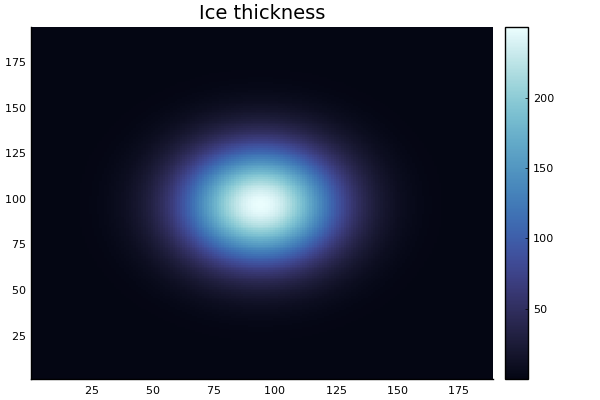

In [412]:
# JUST RUN THIS FOR SYNTHETIC CASE
# Simulated example

B = zeros(Float64, (nx, ny))
σ = 1000
H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / σ ) for i in 1:nx, j in 1:ny ]

Δx = Δy = 10 #m (Δx = Δy)

heatmap(H₀, c = :ice, title="Ice thickness")

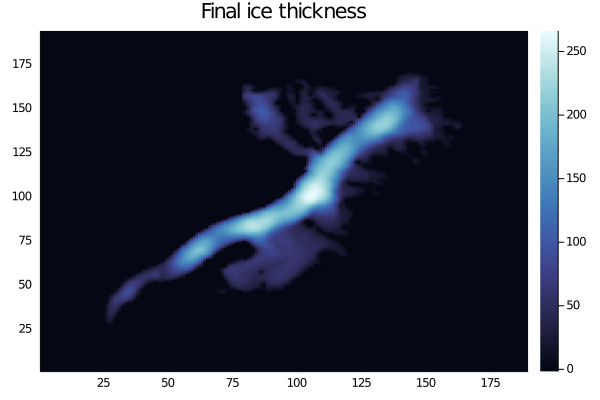

In [10]:
# Dynamical Ice thickness
H = copy(H₀)
# Time 
t = 0
Δts = []

while t < 1
#for t in 0:Δt:(3*Δt)

    S = copy(B) .+ H

    # Grid that is between the points in the original glacier grid. 
    staggered_grid = zeros(Float64, (nx-1, ny-1));

    staggered_grid = ( (
            H[1:end-1, 1:end-1] .+ 
            H[2:end, 1:end-1] .+
            H[1:end-1, 2:end] .+
            H[2:end, 2:end] ) ./ 4 ) .^ (n+2)

    staggered_grid .*= ( ( 0.5 * ( ( S[1:end-1, 2:end] .- S[1:end-1, 1:end-1] ) ./ Δy .+ 
                ( S[2:end, 2:end] .- S[2:end, 1:end-1] ) ./ Δy ) ) .^ 2 .+
                         ( 0.5 * ( ( S[2:end, 1:end-1] .- S[1:end-1, 1:end-1] ) ./ Δx .+ 
                ( S[2:end, 2:end] .- S[1:end-1, 2:end] ) ./ Δx ) ) .^ 2 ) .^ (2 / (n-1))

    staggered_grid *= Γ      # m / s^2
    
    
    max_diffusivity = maximum(staggered_grid)
    Δt = η * ( Δx^2 / ( 2 * max_diffusivity ) )
    append!(Δts, Δt)
    
    μx = Δt / (Δx ^ 2)
    μy = Δt / (Δy ^ 2)
    t += Δt
    #println("time: ", t)
    
    #stability_coefficient = 2 * μx * max_diffusivity
    #println("Stability coefficient should be less than 1:", stability_coefficient)
    

    # Once we have the diffusivity computed on the staggered grid, we can compute the diffusivity on the edges

    for j in 2:(nx - 1)
        for k in 2:(ny-1)

            diffusivity₊₀ = ( staggered_grid[j, k] + staggered_grid[j, k - 1] ) / 2
            diffusivity₋₀ = ( staggered_grid[j-1, k] + staggered_grid[j - 1, k - 1] ) / 2
            diffusivity₀₊ = ( staggered_grid[j, k] + staggered_grid[j - 1, k] ) / 2
            diffusivity₀₋ = ( staggered_grid[j, k-1] + staggered_grid[j - 1, k - 1] ) / 2

            ΔH = μx * ( diffusivity₊₀ * ( S[j+1,k] - S[j,k] ) - diffusivity₋₀ * ( S[j,k] - S[j-1,k] ) ) +
                 μy * ( diffusivity₀₊ * ( S[j,k+1] - S[j,k] ) - diffusivity₀₋ * ( S[j,k] - S[j,k-1] ) )
            
            global H[j,k] += ΔH

        end
    end

end 

heatmap(H, c = :ice, title="Final ice thickness")

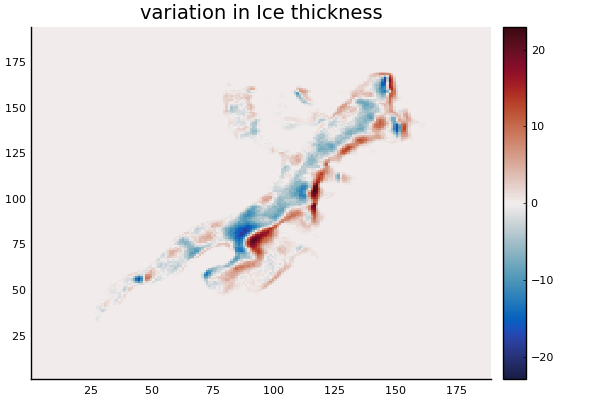

In [22]:
lim = maximum( abs.(H .- H₀) )

hm02 = heatmap(H₀ .- H, c = :balance, clim = (-lim, lim), title="variation in Ice thickness")

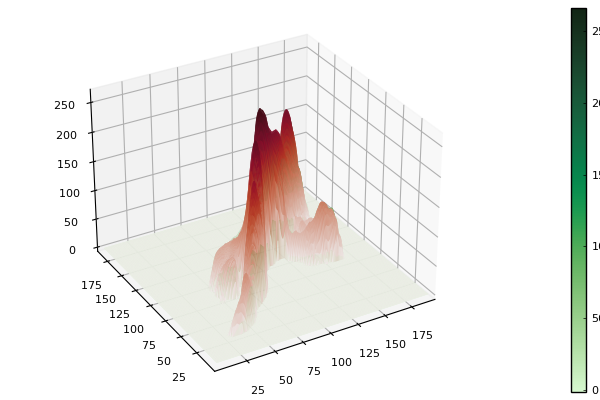

In [15]:
using Plots; pyplot()
x=1:nx
y=1:ny
f₀(x,y) = H₀[x,y]
f(x,y) = H[x,y]
plot(x,y,f₀,st=:surface,c=cgrad(:algae),camera=(-30,30), fillalpha = 1)
plot!(x,y,f,st=:surface,c=cgrad(:amp),camera=(-30,30), fillalpha = 1)

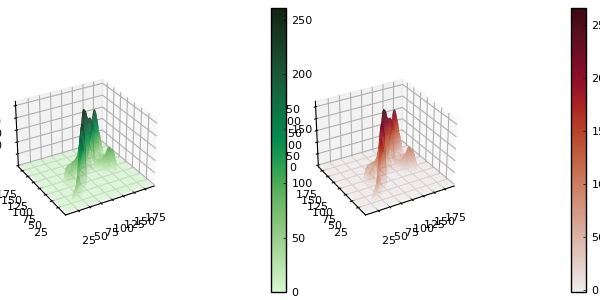

In [16]:
hm01 = plot(x,y,f₀,st=:surface,c=cgrad(:algae),camera=(-30,30), fillalpha = 1)
hm02 = plot(x,y,f,st=:surface,c=cgrad(:amp),camera=(-30,30), fillalpha = 1)
hm0 = plot(hm01,hm02, layout=(1,2), size=(600,300) )
#display(hm0)

We can plot the $\Delta t$ use in the adaptive method as a function of the iterations:

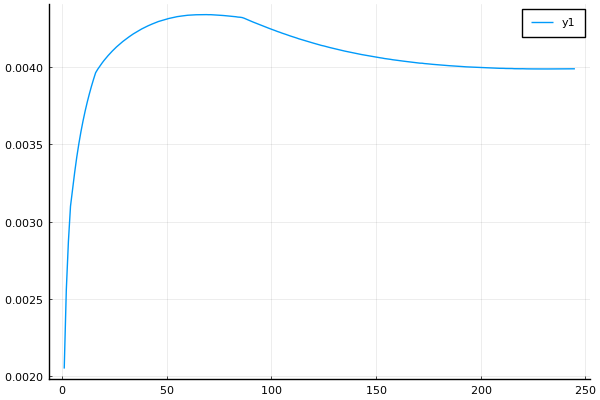

In [17]:
plot(Δts)